In [1]:
import sys
sys.path.insert(0, "/cndd/fangming/CEMBA/snmcseq_dev")

from multiprocessing import Pool,cpu_count
from functools import partial

from scipy import sparse
from scipy import stats
from scipy import optimize
import importlib
from __init__ import *
from __init__jupyterlab import *
import snmcseq_utils
importlib.reload(snmcseq_utils)

import re
import pickle
import datetime
from scipy import optimize

import tqdm

import importlib
sys.path.insert(0, '../')
import enhancer_gene_utils
importlib.reload(enhancer_gene_utils)
from enhancer_gene_utils import get_corr_stats



In [2]:
today = datetime.date.today()
print(today)

2021-10-25


# Plot mC, ATAC, both (one knn, different metacells)
### - 80% cells for 5-time downsampling

In [3]:
input_enh_gene_table = '/cndd2/fangming/projects/scf_enhancers/results/200521_to_evals.tsv' 
output_figures = '/cndd2/fangming/projects/scf_enhancers/results/figures/{}_metacell_corr_res_{{}}.pdf'.format(today)
output_res = '/cndd2/fangming/projects/scf_enhancers/results/{}_metacell_corr_res_{{}}'.format(today)

print(output_figures, output_res)

/cndd2/fangming/projects/scf_enhancers/results/figures/2021-10-25_metacell_corr_res_{}.pdf /cndd2/fangming/projects/scf_enhancers/results/2021-10-25_metacell_corr_res_{}


In [4]:
# enhancer-gene linkage
ti = time.time()
enhancer_gene_to_eval = (pd.read_csv(input_enh_gene_table, sep='\t')
                             [['gene', 'ens', 'dist']]
                             .rename(columns={'ens': 'enh'})
                        )

print(enhancer_gene_to_eval.shape)
print(time.time()-ti)
enhancer_gene_to_eval.head()

(2589994, 3)
11.242812156677246


,gene,enh,dist
0,ENSMUSG00000000001,147520,995118
1,ENSMUSG00000000001,147522,985740
2,ENSMUSG00000000001,147523,983725
3,ENSMUSG00000000001,147527,970444
4,ENSMUSG00000000001,147528,969372


In [5]:
# read from grand summary?
knn = 30
# input_summary = '/cndd2/fangming/projects/scf_enhancers/results/{}_metacell_corr_res_{{}}'.format(today)
input_summary = '/cndd2/fangming/projects/scf_enhancers/results/2021-01-08_metacell_corr_res_grand_res_summary_table.tsv.gz'
iterator_both = pd.read_csv(input_summary, sep='\t')

iterator_both = iterator_both.query("k == {}".format(knn))
print(iterator_both.shape)
iterator_both.head()

(150, 46)


,r,i,k,fname_mc,fname_atac,num_linked_pairs_mc,num_linked_genes_mc,num_linked_enhs_mc,id_linked_pairs_mc,num_correlated_pairs_mc,...,num_linked_genes_both,num_linked_enhs_both,num_correlated_pairs_both,num_correlated_genes_both,num_correlated_enhs_both,num_total_pairs_both,num_total_genes_both,num_total_enhs_both,rM,num_clst
2,1.0,0,30,/cndd2/fangming/projects/scf_enhancers/results...,/cndd2/fangming/projects/scf_enhancers/results...,3782,1417,3551,[ 475 481 487 ... 2585888 2586076 2...,52814,...,241,341,20715,6424,16902,219808,16157,95613,1000000,16
7,1.0,1,30,/cndd2/fangming/projects/scf_enhancers/results...,/cndd2/fangming/projects/scf_enhancers/results...,2504,1069,2384,[ 475 481 485 ... 2585888 2586075 2...,56880,...,126,166,12439,4938,10581,219808,16157,95613,1000000,15
12,1.0,2,30,/cndd2/fangming/projects/scf_enhancers/results...,/cndd2/fangming/projects/scf_enhancers/results...,2252,983,2148,[ 475 1540 1542 ... 2586075 2586076 2...,55236,...,127,169,13170,4977,11174,219808,16157,95613,1000000,14
17,1.0,3,30,/cndd2/fangming/projects/scf_enhancers/results...,/cndd2/fangming/projects/scf_enhancers/results...,3782,1333,3543,[ 475 497 698 ... 2574238 2577583 2...,66434,...,247,347,26663,7638,21307,219808,16157,95613,1000000,17
22,1.0,4,30,/cndd2/fangming/projects/scf_enhancers/results...,/cndd2/fangming/projects/scf_enhancers/results...,1977,893,1884,[ 475 698 1540 ... 2586075 2586076 2...,45166,...,159,237,13626,4876,11534,219808,16157,95613,1000000,17


In [8]:
iterator_both['r'].unique()

array([  1.        ,   1.25892541,   1.58489319,   1.99526231,
         2.51188643,   3.16227766,   3.98107171,   5.01187234,
         6.30957344,   7.94328235,  10.        ,  12.58925412,
        15.84893192,  19.95262315,  25.11886432,  31.6227766 ,
        39.81071706,  50.11872336,  63.09573445,  79.43282347,
       100.        , 125.89254118, 158.48931925, 199.5262315 ,
       251.18864315, 316.22776602, 398.10717055, 501.18723363,
       630.95734448, 794.32823472])

In [9]:
iterator_both['num_clst'].unique()

array([  16,   15,   14,   17,   18,   19,   21,   24,   23,   22,   29,
         28,   31,   27,   34,   33,   36,   35,   43,   39,   44,   42,
         50,   51,   62,   60,   71,   73,   70,   93,   87,   90,   82,
         89,  109,  108,  106,  104,  103,  131,  133,  132,  134,  129,
        161,  162,  163,  160,  159,  206,  197,  202,  198,  200,  251,
        240,  249,  259,  254,  307,  306,  304,  314,  302,  376,  378,
        383,  375,  381,  478,  474,  472,  481,  590,  586,  578,  592,
        732,  718,  733,  727,  912,  898,  901,  902,  907, 1143, 1142,
       1120, 1133, 1412, 1424, 1453, 1419, 1414, 1811, 1838, 1816, 1812,
       1802, 2315, 2324, 2342, 2300, 2996, 2962, 2988, 2978, 2971, 3860,
       3844, 3833, 3827, 3868, 5025, 4974, 5013, 4968, 4996, 6600, 6561,
       6556, 6543, 6546, 8850, 8749, 8808, 8776, 8833])

## Plot out one ATAC example distribution 

In [6]:
def prep_plot_dist_both(
    row,
    enhancer_gene_to_eval,
    colors_mc, colors_atac, colors_null, 
    ATAC_SIGN=-1,
    ):
    """
    """
    fname1, fname2 = row['fname_mc'], row['fname_atac']

    ## organize data; get results
    # get corrs
    with open(fname1, 'rb') as fh:
        to_correlate, corrs, corrs_shuffled, corrs_shuffled_cells = pickle.load(fh)
    res_corrs = enhancer_gene_to_eval[to_correlate].copy()
    res_corrs['corr'] = corrs 
    res_corrs['corr_shuff'] = corrs_shuffled
    res_corrs['corr_shuff_cells'] = corrs_shuffled_cells

    # get corrs
    with open(fname2, 'rb') as fh:
        to_correlate, corrs, corrs_shuffled, corrs_shuffled_cells = pickle.load(fh)
    res2_corrs = enhancer_gene_to_eval[to_correlate].copy()
    res2_corrs['corr'] = corrs 
    res2_corrs['corr_shuff'] = corrs_shuffled
    res2_corrs['corr_shuff_cells'] = corrs_shuffled_cells

    labels_base = [
              'shuffled cell types',
              'shuffled regions',
              '<500kb',
              '<100kb',
             ] 
    subsample_rates = [
                      1,
                      1,
                      1,
                      1,
                     ]

    # corr1
    labels = [label+' mCG-RNA' for label in labels_base]
    corr_tracks = [
           res_corrs['corr_shuff_cells'].values,
           res_corrs['corr_shuff'].values,
           res_corrs.loc[res_corrs['dist']<=500*KB, 'corr'].values,
           res_corrs.loc[res_corrs['dist']<=100*KB, 'corr'].values,
          ]
    colors = [colors_null[1], colors_null[0], colors_mc[1], colors_mc[0],]
    vertical_lines = [
        row['r_th_linked_mc'],
        row['r_th_correlated_left_mc'],
        row['r_th_correlated_right_mc'],
    ]

    # corr2
    labels2 = [label+' ATAC-RNA' for label in labels_base]
    corr_tracks2 = [
           res2_corrs['corr_shuff_cells'].values,
           res2_corrs['corr_shuff'].values,
           res2_corrs.loc[res2_corrs['dist']<=500*KB, 'corr'].values,
           res2_corrs.loc[res2_corrs['dist']<=100*KB, 'corr'].values,
          ]
    colors2 = [colors_null[1], colors_null[0], colors_atac[1], colors_atac[0],]
    vertical_lines2 = [
        ATAC_SIGN*row['r_th_linked_atac'],
        ATAC_SIGN*row['r_th_correlated_left_atac'],
        ATAC_SIGN*row['r_th_correlated_right_atac'],
    ]

    np.random.seed(0)
    corr_tracks = [corr_tracks[i][np.random.rand(len(corr_tracks[i])) < subsample_rates[i]] 
                   for i in range(len(corr_tracks))]
    corr_tracks2 = [corr_tracks2[i][np.random.rand(len(corr_tracks2[i])) < subsample_rates[i]] 
                   for i in range(len(corr_tracks2))]

    return (colors, corr_tracks, labels, vertical_lines,
            colors2, corr_tracks2, labels2, vertical_lines2,
            subsample_rates,
           )


In [7]:
# plot distribution
def plot_dist_both(
    colors, corr_tracks, labels, vertical_lines, 
    colors2, corr_tracks2, labels2, vertical_lines2, 
    bins,
    subsample_rates,
    fancy=True,
    output='',
    ):
    """
    """
    
    with sns.axes_style('ticks', {'axes.grid': False}):
        fig, axs = plt.subplots(2, 1, figsize=(7*1,4*2), sharex=False)
        for i, ax in enumerate(axs):
            if i == 0:
                _colors = colors
                _corr_tracks = corr_tracks
                _labels = labels
                _vertical_lines = vertical_lines
            elif i == 1:
                _colors = colors2
                _corr_tracks = corr_tracks2
                _labels = labels2
                _vertical_lines = vertical_lines2
            fontsize = ax.xaxis.label.get_fontsize()

            # each line (color) is present in all columns; loop over lines
            ax = axs[i]
            histy_max = 0
            for j, (_x, label, color, subsample_rate) in enumerate(zip(
                    _corr_tracks, _labels, _colors, subsample_rates)):
                # go over columns
                label_comp = '{} ({}, frac={})'.format(label, len(_x), subsample_rate)

                g = ax.hist(_x, bins=bins, 
                            histtype='step', 
                            label=label,
                            color=color, density=True)
                histy, histx, _ = g
                if j == 0:
                    histy0_max = np.max(histy)
                    histx0_max = bins[np.argmax(histy)]
                if j > 0:
                    histy_max = max(histy_max, np.max(histy)) 

            ax.set_ylim([0, 1.3*histy_max])
            if histy0_max > 1.3*histy_max:
                # text
                text_config = {
                    'xy': (histx0_max, 1.3*histy_max), 
                    'ha': 'center', 'va': 'bottom', 
                    'xytext': (0, 0),
                    'textcoords': 'offset points',
                    'fontsize': 0.7*fontsize,
                }
                ax.annotate("{:.2f}".format(histy0_max), **text_config)

            # labels
            if i == 1:
                ax.set_xlabel('Spearman correlation')
            ax.set_ylabel('Density')
            ax.set_xlim([-1, 1])
            sns.despine(ax=ax)

            # line ticks
            ax.grid(which='major', axis='x', linestyle='--')
            ax.xaxis.set_major_formatter(mtick.StrMethodFormatter('{x:.2f}'))
            ax.set_xticks(np.sort(np.hstack([[-1, 0, 1], _vertical_lines])))

            # horizontal lines
            lineys = [1.1*histy_max, 1.2*histy_max, 1.2*histy_max]
            linecolors = ['k', 'gray', 'gray']
            texts = ['linked', 'correlated', 'correlated']
            vas = ['top', 'bottom', 'bottom']
            offsets = [(0.2*fontsize, -0.2*fontsize), 
                       (0.2*fontsize, +0.2*fontsize), 
                       (0.2*fontsize, +0.2*fontsize), 
                      ]
            for xcoord, linecolor, liney, text, va, offset in zip(
                _vertical_lines, linecolors, lineys, texts, vas, offsets):
                if xcoord < 0:
                    _x = -1
                    xmin, xmax = -1, xcoord
                    ha = 'left'
                else:
                    _x = 1
                    xmin, xmax = xcoord, 1 
                    ha = 'right'
                # line
                ax.hlines(liney, xmin=xmin, xmax=xmax, color=linecolor, linestyle='-')
                # text
                text_config = {
                    'xy': (_x, liney), 
                    'ha': ha, 'va': va, 
                    'xytext': offset,
                    'textcoords': 'offset points',
                    'fontsize': fontsize,
                }
                ax.annotate(text, **text_config)

        if fancy:
            # title
            axs[0].set_title('mCG-RNA', y=1.1)
            axs[1].set_title('ATAC-RNA', y=1.1)
            
            # combined legend
            r = EMPTY_RECTANGLE
            handles, labels = snmcseq_utils.combine_legends(axs.flat)
            handles = list(handles)
            labels = list(labels)
            # line orders
            _labels = [" ".join(label.split(' ')[:-1])for label in labels]
            _handles = [r] + handles[:4] + [r] + handles[4:]
            # turn it into lines
            _handles = [mpl.lines.Line2D([], [], c=h.get_edgecolor()) for h in _handles]
            _labels = ['mCG-RNA'] + ['']*4 + ['ATAC-RNA'] + _labels[4:]
            axs[0].legend(_handles, _labels, ncol=2,
                      bbox_to_anchor=(1,1), loc='upper left')
            
            # text
            text_config = {
                'xy': (1, 0.5*histy_max), 
                'ha': 'right', 'va': 'top', 
                'xytext': (0, 0),
                'textcoords': 'offset points',
                'fontsize': 0.7*fontsize,
            }
            ax.annotate('FDR={:.2f}'.format(fdr_th), **text_config)

        # adjust
        fig.subplots_adjust(hspace=0.5)
        # savefig
        if output:
            fig.savefig(output, bbox_inches='tight')
        plt.show()

In [8]:
# plot distribution
def plot_dist_ax(
    ax,
    _colors, _corr_tracks, _labels, _vertical_lines, subsample_rates,
    ):
    """
    """
    fontsize = ax.xaxis.label.get_fontsize()

    # each line (color) is present in all columns; loop over lines
    histy_max = 0
    for j, (_x, label, color, subsample_rate) in enumerate(zip(
            _corr_tracks, _labels, _colors, subsample_rates)):
        # go over columns
        label_comp = '{} ({}, frac={})'.format(label, len(_x), subsample_rate)

        g = ax.hist(_x, bins=bins, 
                    histtype='step', 
                    label=label,
                    color=color, density=True)
        histy, histx, _ = g
        if j == 0:
            histy0_max = np.max(histy)
            histx0_max = bins[np.argmax(histy)]
        if j > 0:
            histy_max = max(histy_max, np.max(histy)) 

    ax.set_ylim([0, 1.3*histy_max])
    if histy0_max > 1.3*histy_max:
        # text
        text_config = {
            'xy': (histx0_max, 1.3*histy_max), 
            'ha': 'center', 'va': 'bottom', 
            'xytext': (0, 0),
            'textcoords': 'offset points',
            'fontsize': 0.7*fontsize,
        }
        ax.annotate("{:.2f}".format(histy0_max), **text_config)

    # labels
    ax.set_xlabel('Spearman correlation')
    ax.set_ylabel('Density')
    ax.set_xlim([-1, 1])
    sns.despine(ax=ax)

    # line ticks
    ax.grid(which='major', axis='x', linestyle='--')
    ax.xaxis.set_major_formatter(mtick.StrMethodFormatter('{x:.2f}'))
    ax.set_xticks(np.sort(np.hstack([[-1, 0, 1], _vertical_lines])))

    # horizontal lines
    lineys = [1.1*histy_max, 1.2*histy_max, 1.2*histy_max]
    linecolors = ['k', 'gray', 'gray']
    texts = ['linked', 'correlated', 'correlated']
    vas = ['top', 'bottom', 'bottom']
    offsets = [(0.2*fontsize, -0.2*fontsize), 
               (0.2*fontsize, +0.2*fontsize), 
               (0.2*fontsize, +0.2*fontsize), 
              ]
    for xcoord, linecolor, liney, text, va, offset in zip(
        _vertical_lines, linecolors, lineys, texts, vas, offsets):
        if xcoord < 0:
            _x = -1
            xmin, xmax = -1, xcoord
            ha = 'left'
        else:
            _x = 1
            xmin, xmax = xcoord, 1 
            ha = 'right'
        # line
        ax.hlines(liney, xmin=xmin, xmax=xmax, color=linecolor, linestyle='-')
        # text
        text_config = {
            'xy': (_x, liney), 
            'ha': ha, 'va': va, 
            'xytext': offset,
            'textcoords': 'offset points',
            'fontsize': fontsize,
        }
        ax.annotate(text, **text_config)
    
    return 

In [9]:
# basic setup

KB = 1000
# color palette
cm = plt.cm.tab20c.colors
# settle down on a color palette
colors_mc = [cm[8], cm[9], cm[10],]
colors_atac = [cm[0], cm[1], cm[2],]
colors_null = ['black', cm[16], cm[17], cm[18],]
color_tracks = [
    cm,
    colors_mc,
    colors_atac,
    colors_null,
]
labels = [
    'All',
    'mC',
    'ATAC',
    'Null',
]

ATAC_SIGN = -1
bins = np.linspace(-1, 1, 501)
labels_base = [
          'shuffled cell types',
          'shuffled regions',
          '<500kb',
          '<100kb',
         ] 
track_color_palette = {
    labels_base[0]+'_'+'mc': colors_null[1],
    labels_base[1]+'_'+'mc': colors_null[0],
    labels_base[2]+'_'+'mc': colors_mc[1],
    labels_base[3]+'_'+'mc': colors_mc[0],
    
    labels_base[0]+'_'+'atac': colors_null[1],
    labels_base[1]+'_'+'atac': colors_null[0],
    labels_base[2]+'_'+'atac': colors_atac[1],
    labels_base[3]+'_'+'atac': colors_atac[0],
}

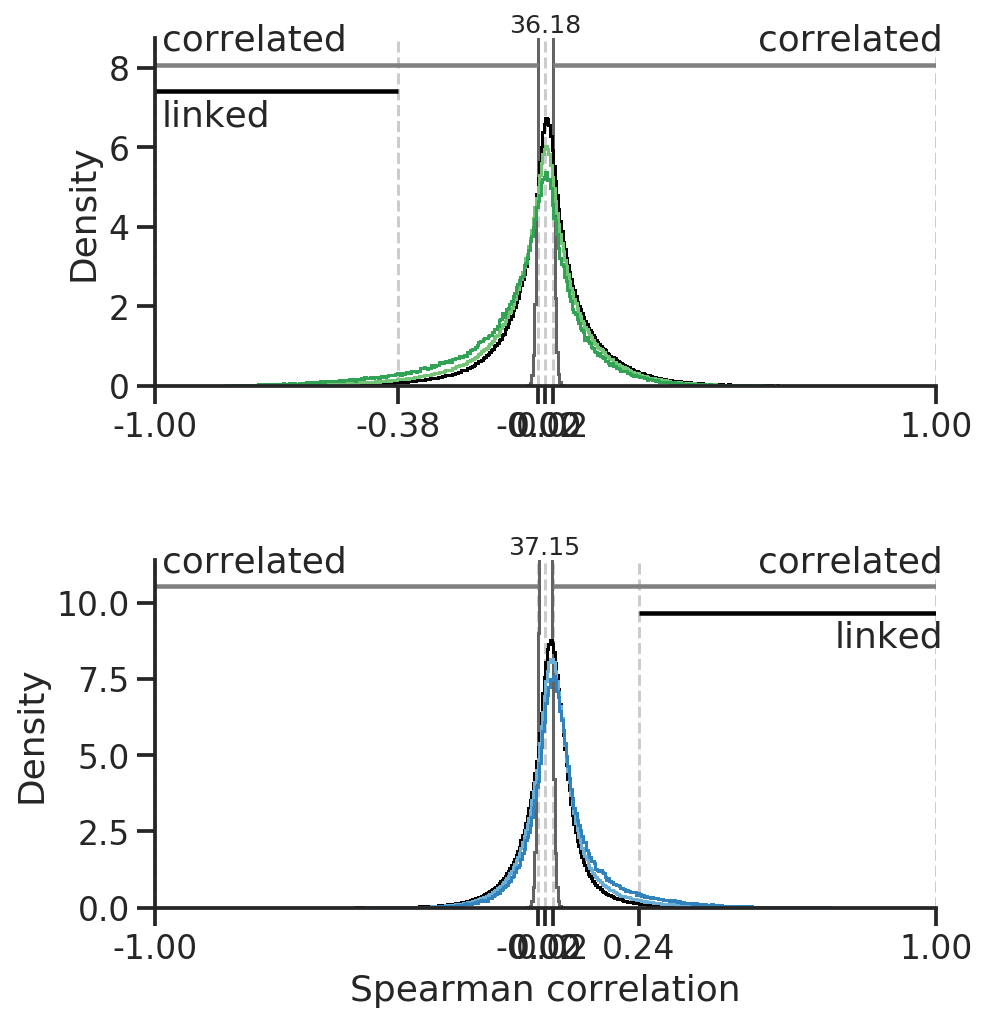

In [10]:
row = iterator_both[iterator_both['r'] == iterator_both['r'].max()].iloc[0]

## plot
# output = output_figures.format('hist_corr_both')
# print(output)

# prep plot
(colors, corr_tracks, labels, vertical_lines,
 colors2, corr_tracks2, labels2, vertical_lines2,
 subsample_rates,) = prep_plot_dist_both(row, 
                                         enhancer_gene_to_eval,
                                         colors_mc, colors_atac, colors_null, 
                                         ATAC_SIGN=ATAC_SIGN,
                                        )
# plot
plot_dist_both(
    colors, corr_tracks, labels, vertical_lines, 
    colors2, corr_tracks2, labels2, vertical_lines2, 
    bins,
    subsample_rates,
    fancy=False,
#     output=output,
    )

# apply to all

In [11]:
# this step is time consuming


res_all = []
for idx, row in tqdm.tqdm(iterator_both.sort_values(['r', 'i'])
#                           .iloc[:2]
                          .iterrows()): 
    # prep plot
    (colors, corr_tracks, labels, vertical_lines,
     colors2, corr_tracks2, labels2, vertical_lines2,
     subsample_rates,) = prep_plot_dist_both(row, 
                                             enhancer_gene_to_eval,
                                             colors_mc, colors_atac, colors_null, 
                                             ATAC_SIGN=ATAC_SIGN,
                                            )
    
    res_all.append([row['r'], row['i'], row['k'], row['num_clst'], 
                    colors, corr_tracks, labels, vertical_lines,
                    colors2, corr_tracks2, labels2, vertical_lines2,
                    subsample_rates,])

res_all = pd.DataFrame(res_all, columns=[
    'r', 'i', 'k', 'num_clst', 'colors', 'corr_tracks', 'labels', 'vertical_lines',
    'colors2', 'corr_tracks2', 'labels2', 'vertical_lines2',
    'subsample_rates',])
print(res_all.shape)
res_all.head()

150it [03:31,  1.41s/it]


(150, 13)


,r,i,k,num_clst,colors,corr_tracks,labels,vertical_lines,colors2,corr_tracks2,labels2,vertical_lines2,subsample_rates
0,1.0,0,30,16,"[(0.38823529411764707, 0.38823529411764707, 0....","[[0.37009803921568635, -0.06372549019607844, 0...","[shuffled cell types mCG-RNA, shuffled regions...","[-0.8148695971944259, -0.4949372951278482, 0.5...","[(0.38823529411764707, 0.38823529411764707, 0....","[[-0.02647058823529412, 0.20294117647058824, 0...","[shuffled cell types ATAC-RNA, shuffled region...","[0.8530817592953669, 0.5293082612136605, -0.51...","[1, 1, 1, 1]"
1,1.0,1,30,15,"[(0.38823529411764707, 0.38823529411764707, 0....","[[0.15294117647058822, -0.4323529411764706, -0...","[shuffled cell types mCG-RNA, shuffled regions...","[-0.8405934172972324, -0.4765652469716157, 0.4...","[(0.38823529411764707, 0.38823529411764707, 0....","[[0.15, -0.01428571428571431, 0.21505514481979...","[shuffled cell types ATAC-RNA, shuffled region...","[0.8760487950689667, 0.6421308883308708, -0.58...","[1, 1, 1, 1]"
2,1.0,2,30,14,"[(0.38823529411764707, 0.38823529411764707, 0....","[[-0.04705882352941179, -0.1882352941176471, -...","[shuffled cell types mCG-RNA, shuffled regions...","[-0.8537731053216988, -0.5112880294413146, 0.5...","[(0.38823529411764707, 0.38823529411764707, 0....","[[-0.17362637362637365, 0.028571428571428574, ...","[shuffled cell types ATAC-RNA, shuffled region...","[0.8918945362835046, 0.656219122600681, -0.611...","[1, 1, 1, 1]"
3,1.0,3,30,17,"[(0.38823529411764707, 0.38823529411764707, 0....","[[0.0686274509803922, 0.18627450980392157, 0.3...","[shuffled cell types mCG-RNA, shuffled regions...","[-0.8051215635489531, -0.4409985021706913, 0.4...","[(0.38823529411764707, 0.38823529411764707, 0....","[[-0.16176470588235303, -0.1813725490196079, 0...","[shuffled cell types ATAC-RNA, shuffled region...","[0.8544063287875797, 0.480280078060933, -0.464...","[1, 1, 1, 1]"
4,1.0,4,30,17,"[(0.38823529411764707, 0.38823529411764707, 0....","[[-0.07142857142857141, -0.21071428571428566, ...","[shuffled cell types mCG-RNA, shuffled regions...","[-0.8640623213650201, -0.5767054029668693, 0.4...","[(0.38823529411764707, 0.38823529411764707, 0....","[[-0.12998163080761713, -0.2892156862745099, 0...","[shuffled cell types ATAC-RNA, shuffled region...","[0.844726371325213, 0.5785102140954754, -0.557...","[1, 1, 1, 1]"


In [12]:
# save this bit 
output = output_res.format('summary_dist_table_knn{}.pkl'.format(knn))
print(output)

with open(output, 'wb') as fh:
    pickle.dump(res_all, fh)

/cndd2/fangming/projects/scf_enhancers/results/2021-01-08_metacell_corr_res_summary_dist_table_knn30.pkl


In [13]:
# the above steps are time consuming; try skip by use this
# input_res_all = output
input_res_all = '/cndd2/fangming/projects/scf_enhancers/results/2020-12-27_metacell_corr_res_summary_dist_table_knn30.pkl'
with open(input_res_all, 'rb') as fh:
    res_all = pickle.load(fh)
    
print(res_all.shape)
res_all.head()

(150, 13)


,r,i,k,num_clst,colors,corr_tracks,labels,vertical_lines,colors2,corr_tracks2,labels2,vertical_lines2,subsample_rates
0,1.0,0,30,16,"[(0.38823529411764707, 0.38823529411764707, 0....","[[0.37009803921568635, -0.06372549019607844, 0...","[shuffled cell types mCG-RNA, shuffled regions...","[-0.8148695971944259, -0.4949372951278482, 0.5...","[(0.38823529411764707, 0.38823529411764707, 0....","[[-0.02647058823529412, 0.20294117647058824, 0...","[shuffled cell types ATAC-RNA, shuffled region...","[0.8530817592953669, 0.5293082612136605, -0.51...","[1, 1, 1, 1]"
1,1.0,1,30,15,"[(0.38823529411764707, 0.38823529411764707, 0....","[[0.15294117647058822, -0.4323529411764706, -0...","[shuffled cell types mCG-RNA, shuffled regions...","[-0.8405934172972324, -0.4765652469716157, 0.4...","[(0.38823529411764707, 0.38823529411764707, 0....","[[0.15, -0.01428571428571431, 0.21505514481979...","[shuffled cell types ATAC-RNA, shuffled region...","[0.8760487950689667, 0.6421308883308708, -0.58...","[1, 1, 1, 1]"
2,1.0,2,30,14,"[(0.38823529411764707, 0.38823529411764707, 0....","[[-0.04705882352941179, -0.1882352941176471, -...","[shuffled cell types mCG-RNA, shuffled regions...","[-0.8537731053216988, -0.5112880294413146, 0.5...","[(0.38823529411764707, 0.38823529411764707, 0....","[[-0.17362637362637365, 0.028571428571428574, ...","[shuffled cell types ATAC-RNA, shuffled region...","[0.8918945362835046, 0.656219122600681, -0.611...","[1, 1, 1, 1]"
3,1.0,3,30,17,"[(0.38823529411764707, 0.38823529411764707, 0....","[[0.0686274509803922, 0.18627450980392157, 0.3...","[shuffled cell types mCG-RNA, shuffled regions...","[-0.8051215635489531, -0.4409985021706913, 0.4...","[(0.38823529411764707, 0.38823529411764707, 0....","[[-0.16176470588235303, -0.1813725490196079, 0...","[shuffled cell types ATAC-RNA, shuffled region...","[0.8544063287875797, 0.480280078060933, -0.464...","[1, 1, 1, 1]"
4,1.0,4,30,17,"[(0.38823529411764707, 0.38823529411764707, 0....","[[-0.07142857142857141, -0.21071428571428566, ...","[shuffled cell types mCG-RNA, shuffled regions...","[-0.8640623213650201, -0.5767054029668693, 0.4...","[(0.38823529411764707, 0.38823529411764707, 0....","[[-0.12998163080761713, -0.2892156862745099, 0...","[shuffled cell types ATAC-RNA, shuffled region...","[0.844726371325213, 0.5785102140954754, -0.557...","[1, 1, 1, 1]"


# Plot out 

/cndd2/fangming/projects/scf_enhancers/results/figures/2021-01-08_metacell_corr_res_hist_corr_both_grand.pdf


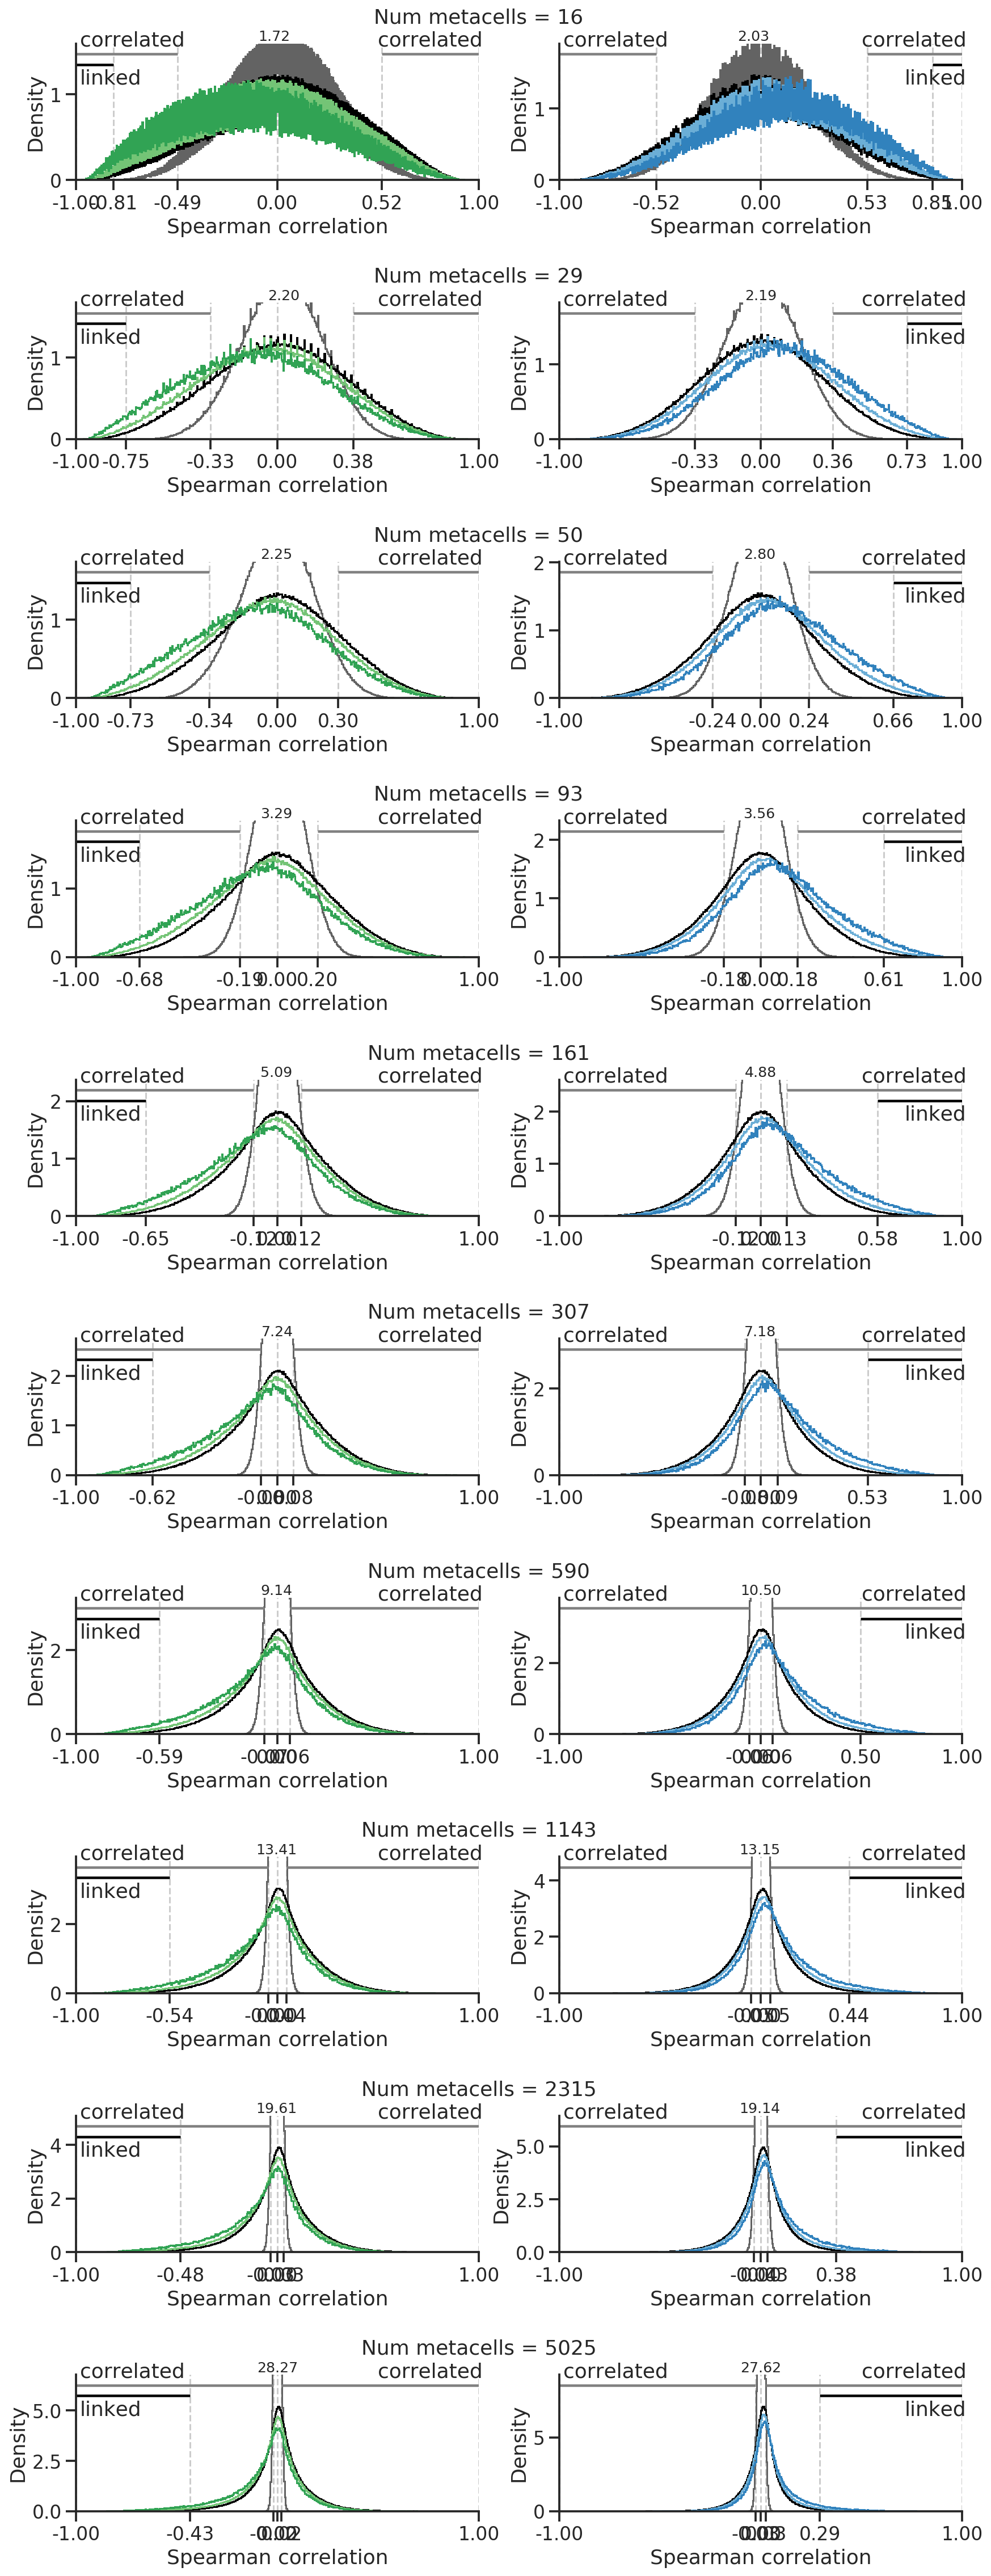

In [14]:
output = output_figures.format('hist_corr_both_grand')
print(output)
toplot = res_all[res_all['i']==0].sort_values(['r']).iloc[::3]
# toplot = res_all

with sns.axes_style('ticks', {'axes.grid': False}):
    n = len(toplot)
    fig, axss = plt.subplots(n, 2, figsize=(7*2,4*n))
    for i, (idx, row) in enumerate(toplot.iterrows()):
        axs = axss[i]
        plot_dist_ax(axs[0], row['colors'], row['corr_tracks'], row['labels'], 
                     row['vertical_lines'], row['subsample_rates'],)
        
        plot_dist_ax(axs[1], row['colors2'], row['corr_tracks2'], row['labels2'], 
                     row['vertical_lines2'], row['subsample_rates'],)
        axs[0].set_title('Num metacells = {}'.format(row['num_clst']), ha='center', loc='right', y=1.1)
    # adjust
    fig.subplots_adjust(hspace=0.9)
    # savefig
    if output:
        fig.savefig(output, bbox_inches='tight')
    plt.show()

# summarize - simple scaling law

In [15]:
# summary
# gray distribution - peak width
# ...

res_summary = []
# n*8 iterations; 150*8 = 1200
for i, (idx, row) in enumerate(res_all.iterrows()):
    # 8 iteration
    for track_name, track in zip(row['labels'], row['corr_tracks']):
        lo = np.nanpercentile(track, 2.5)
        hi = np.nanpercentile(track, 97.5)
        res_summary.append({
            'num_clst': row['num_clst'],
            'r': row['r'],
            'i': row['i'],
            'k': row['k'],
            'track_name': track_name.replace(' mCG-RNA', ''),
            'mod': 'mc',
            'lo': lo,
            'hi': hi,
            'interval': hi-lo,
        })
    for track_name, track in zip(row['labels2'], row['corr_tracks2']):
        lo = np.nanpercentile(track, 2.5)
        hi = np.nanpercentile(track, 97.5)
        res_summary.append({
            'num_clst': row['num_clst'],
            'r': row['r'],
            'i': row['i'],
            'k': row['k'],
            'track_name': track_name.replace(' ATAC-RNA', ''),
            'mod': 'atac',
            'lo': lo,
            'hi': hi,
            'interval': hi-lo,
        })

res_summary = pd.DataFrame(res_summary)
print(res_summary.shape)
res_summary.head()

(1200, 9)


,num_clst,r,i,k,track_name,mod,lo,hi,interval
0,16,1.0,0,30,shuffled cell types,mc,-0.492647,0.514706,1.007353
1,16,1.0,0,30,shuffled regions,mc,-0.676471,0.674020,1.350490
2,16,1.0,0,30,<500kb,mc,-0.727941,0.656863,1.384804
3,16,1.0,0,30,<100kb,mc,-0.789216,0.625000,1.414216
4,16,1.0,0,30,shuffled cell types,atac,-0.494118,0.491176,0.985294


In [16]:
def fit_func_linear(x, alpha, sigma):
    return alpha*x + sigma

# fit iteratively and find the best fit

In [17]:
# plot the fitted results
toplot = res_summary
# aranged by mod and track type
mods = toplot['mod'].unique()
track_names = np.sort(toplot['track_name'].unique())

fit_res = []
for j, mod in enumerate(mods):    
    for i, track_name in enumerate(track_names):    
        label = track_name+'_'+mod
        color = track_color_palette[label]
        toplot_sub = toplot[((toplot['mod']==mod) & (toplot['track_name']==track_name))].sort_values('num_clst')
        
        x, y = toplot_sub['num_clst'], toplot_sub['interval']
        xscaled = 1.0/np.sqrt(x)
        
        for i in np.arange(10, len(x)+1):
            x_tofit = x[:i]
            y_tofit = y[:i]
            xscaled_tofit = xscaled[:i] 
        
            paras, _ = optimize.curve_fit(fit_func_linear, xscaled_tofit, y_tofit)
            y_fit = fit_func_linear(xscaled_tofit, paras[0], paras[1])
            
            r, _ = stats.pearsonr(y_tofit, y_fit)
            r2 = r**2
            fit_res.append({
                'mod': mod,
                'track_name': track_name,
                'num_points': len(x_tofit), 
                'xscaled_last': xscaled_tofit.values[-1], 
                'x_last': x_tofit.values[-1], 
                'r2': r2, 
                 })
fit_res = pd.DataFrame(fit_res)
        
print(fit_res.shape)
fit_res.head()

(1128, 6)


,mod,track_name,num_points,xscaled_last,x_last,r2
0,mc,<100kb,10,0.218218,21,0.169122
1,mc,<100kb,11,0.213201,22,0.303803
2,mc,<100kb,12,0.208514,23,0.366984
3,mc,<100kb,13,0.204124,24,0.497039
4,mc,<100kb,14,0.204124,24,0.508278


/cndd2/fangming/projects/scf_enhancers/results/figures/2021-01-08_metacell_corr_res_num_metacells_scaliing_find_best_fit.pdf


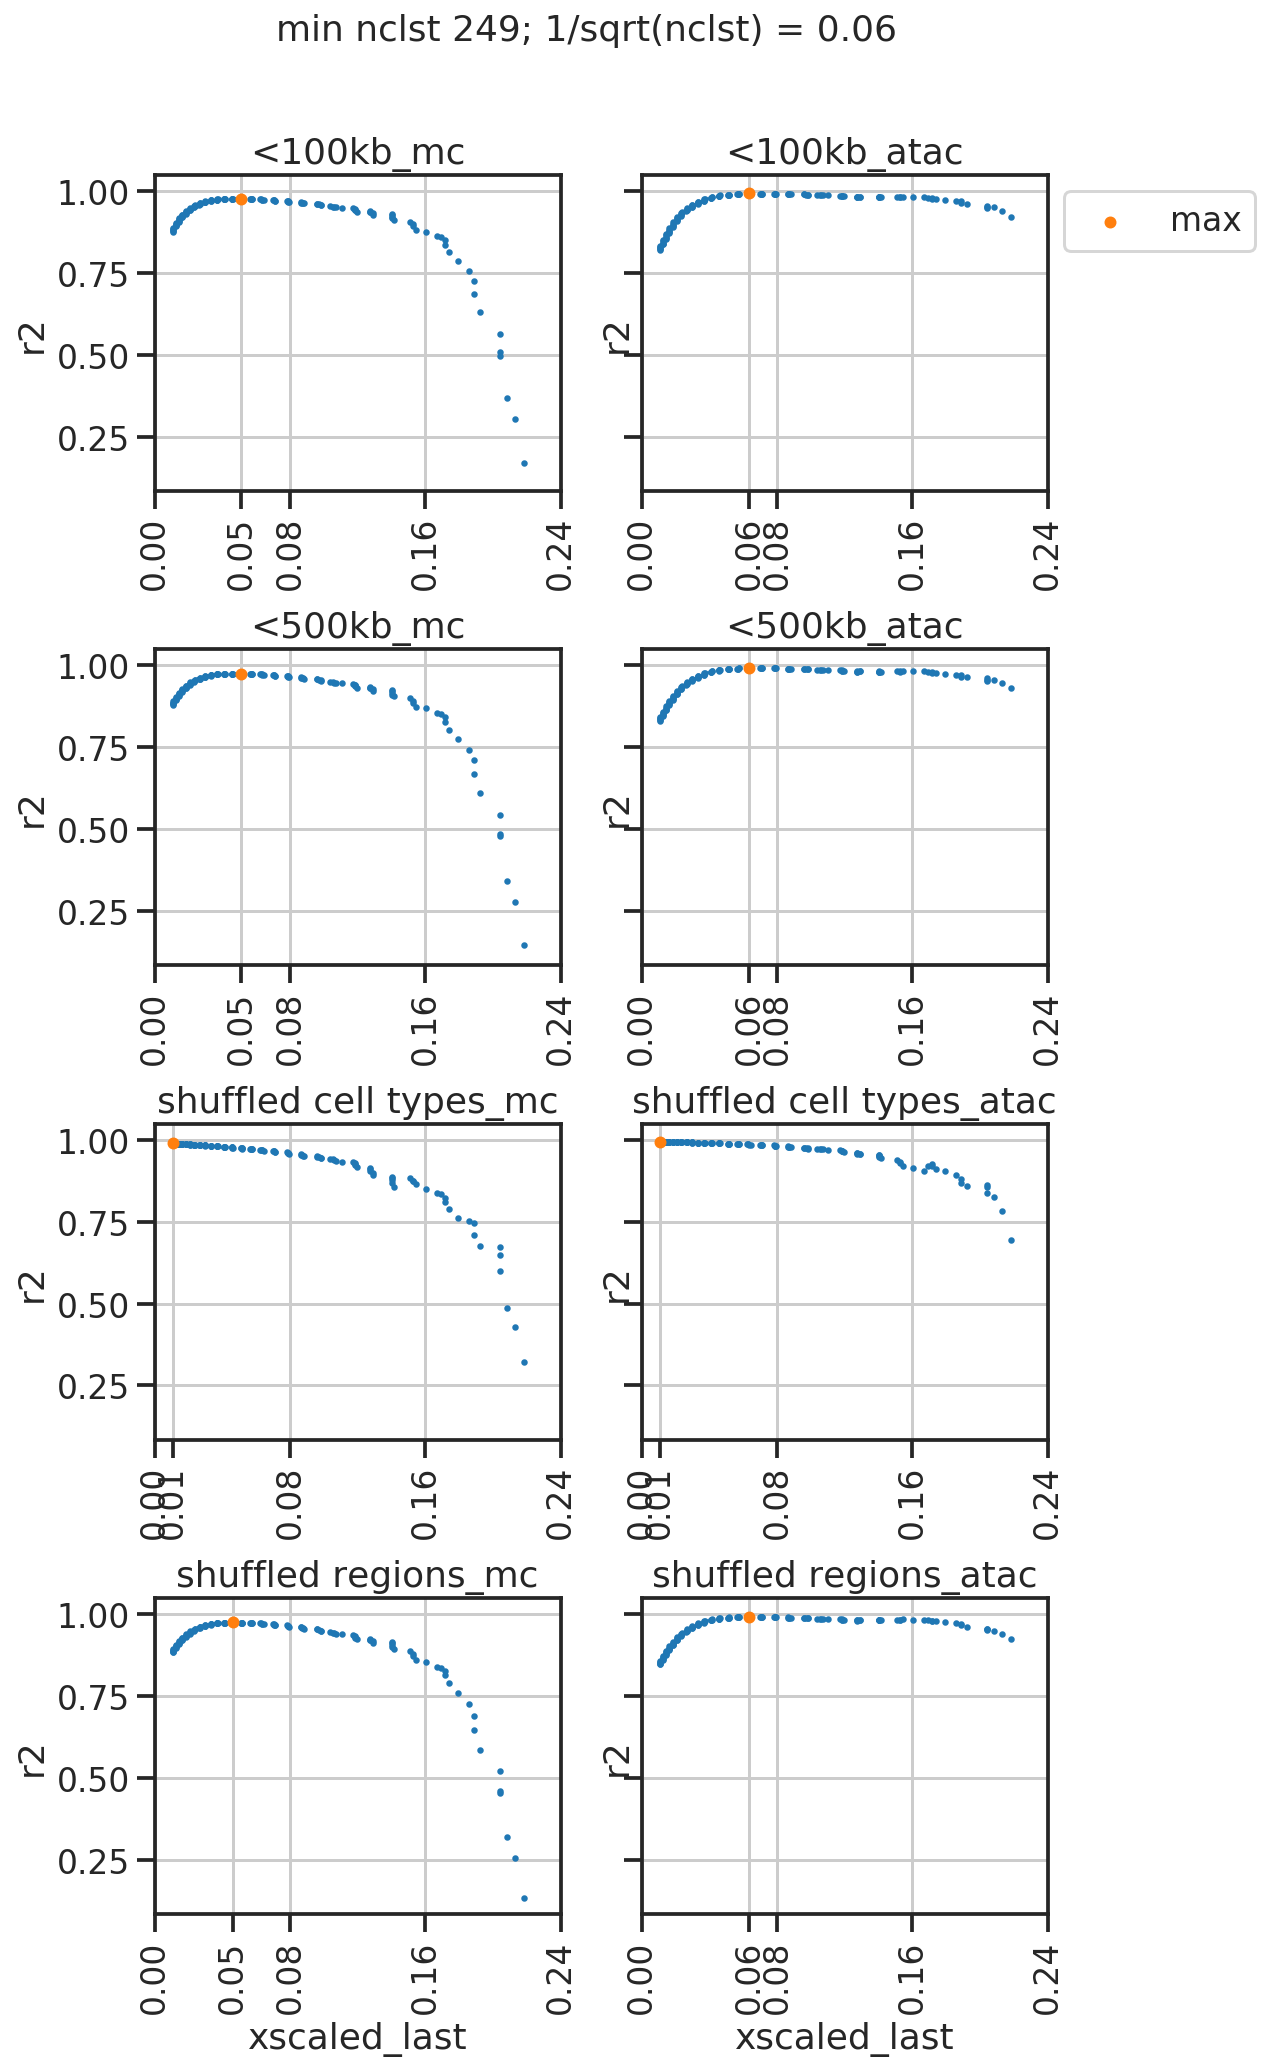

In [18]:
min_nclst_linear = []

fig, axs = plt.subplots(4, 2, figsize=(2*4, 4*4), sharex=False, sharey=True)
for j, mod in enumerate(mods):    
    for i, track_name in enumerate(track_names):    
        ax = axs[i, j]
        label = track_name+'_'+mod
        color = track_color_palette[label]
        toplot_fit_res = fit_res[((fit_res['mod']==mod) & (fit_res['track_name']==track_name))] 
        
        _x = toplot_fit_res['xscaled_last'].values
        _y = toplot_fit_res['r2'].values 
        
        optimum = np.argmax(_y)
        
        min_nclst_linear.append(toplot_fit_res['x_last'].values[optimum])
        ax.scatter(_x, _y, s=3)
        ax.scatter(_x[optimum], _y[optimum], s=20, color='C1', label='max')
    
        xticks = np.sort([0, 0.08, 0.16, 0.24] + [_x[optimum]])
        ax.set_xticks(xticks)
        ax.set_xticklabels(["{:.2f}".format(tick) for tick in xticks], rotation=90)
        ax.set_xlim([xticks[0], xticks[-1]])
        
        ax.set_title(label)
        ax.set_ylabel('r2')
        if i == 3:
            ax.set_xlabel('xscaled_last')

min_nclst_linear = np.min(min_nclst_linear) 
axs[0,1].legend(bbox_to_anchor=(1,1))

fig.suptitle("min nclst {}; 1/sqrt(nclst) = {:.2f}".format(
                min_nclst_linear, 1/np.sqrt(min_nclst_linear)),
                fontsize=18, y=0.95,
            )
fig.subplots_adjust(hspace=0.5)
output = output_figures.format('num_metacells_scaliing_find_best_fit')
if output:
    snmcseq_utils.savefig(fig, output)
    print(output)
plt.show()

# summarize iteration 2 - scaling within certain range 


/cndd2/fangming/projects/scf_enhancers/results/figures/2021-01-08_metacell_corr_res_num_metacells_scaling_fit.pdf


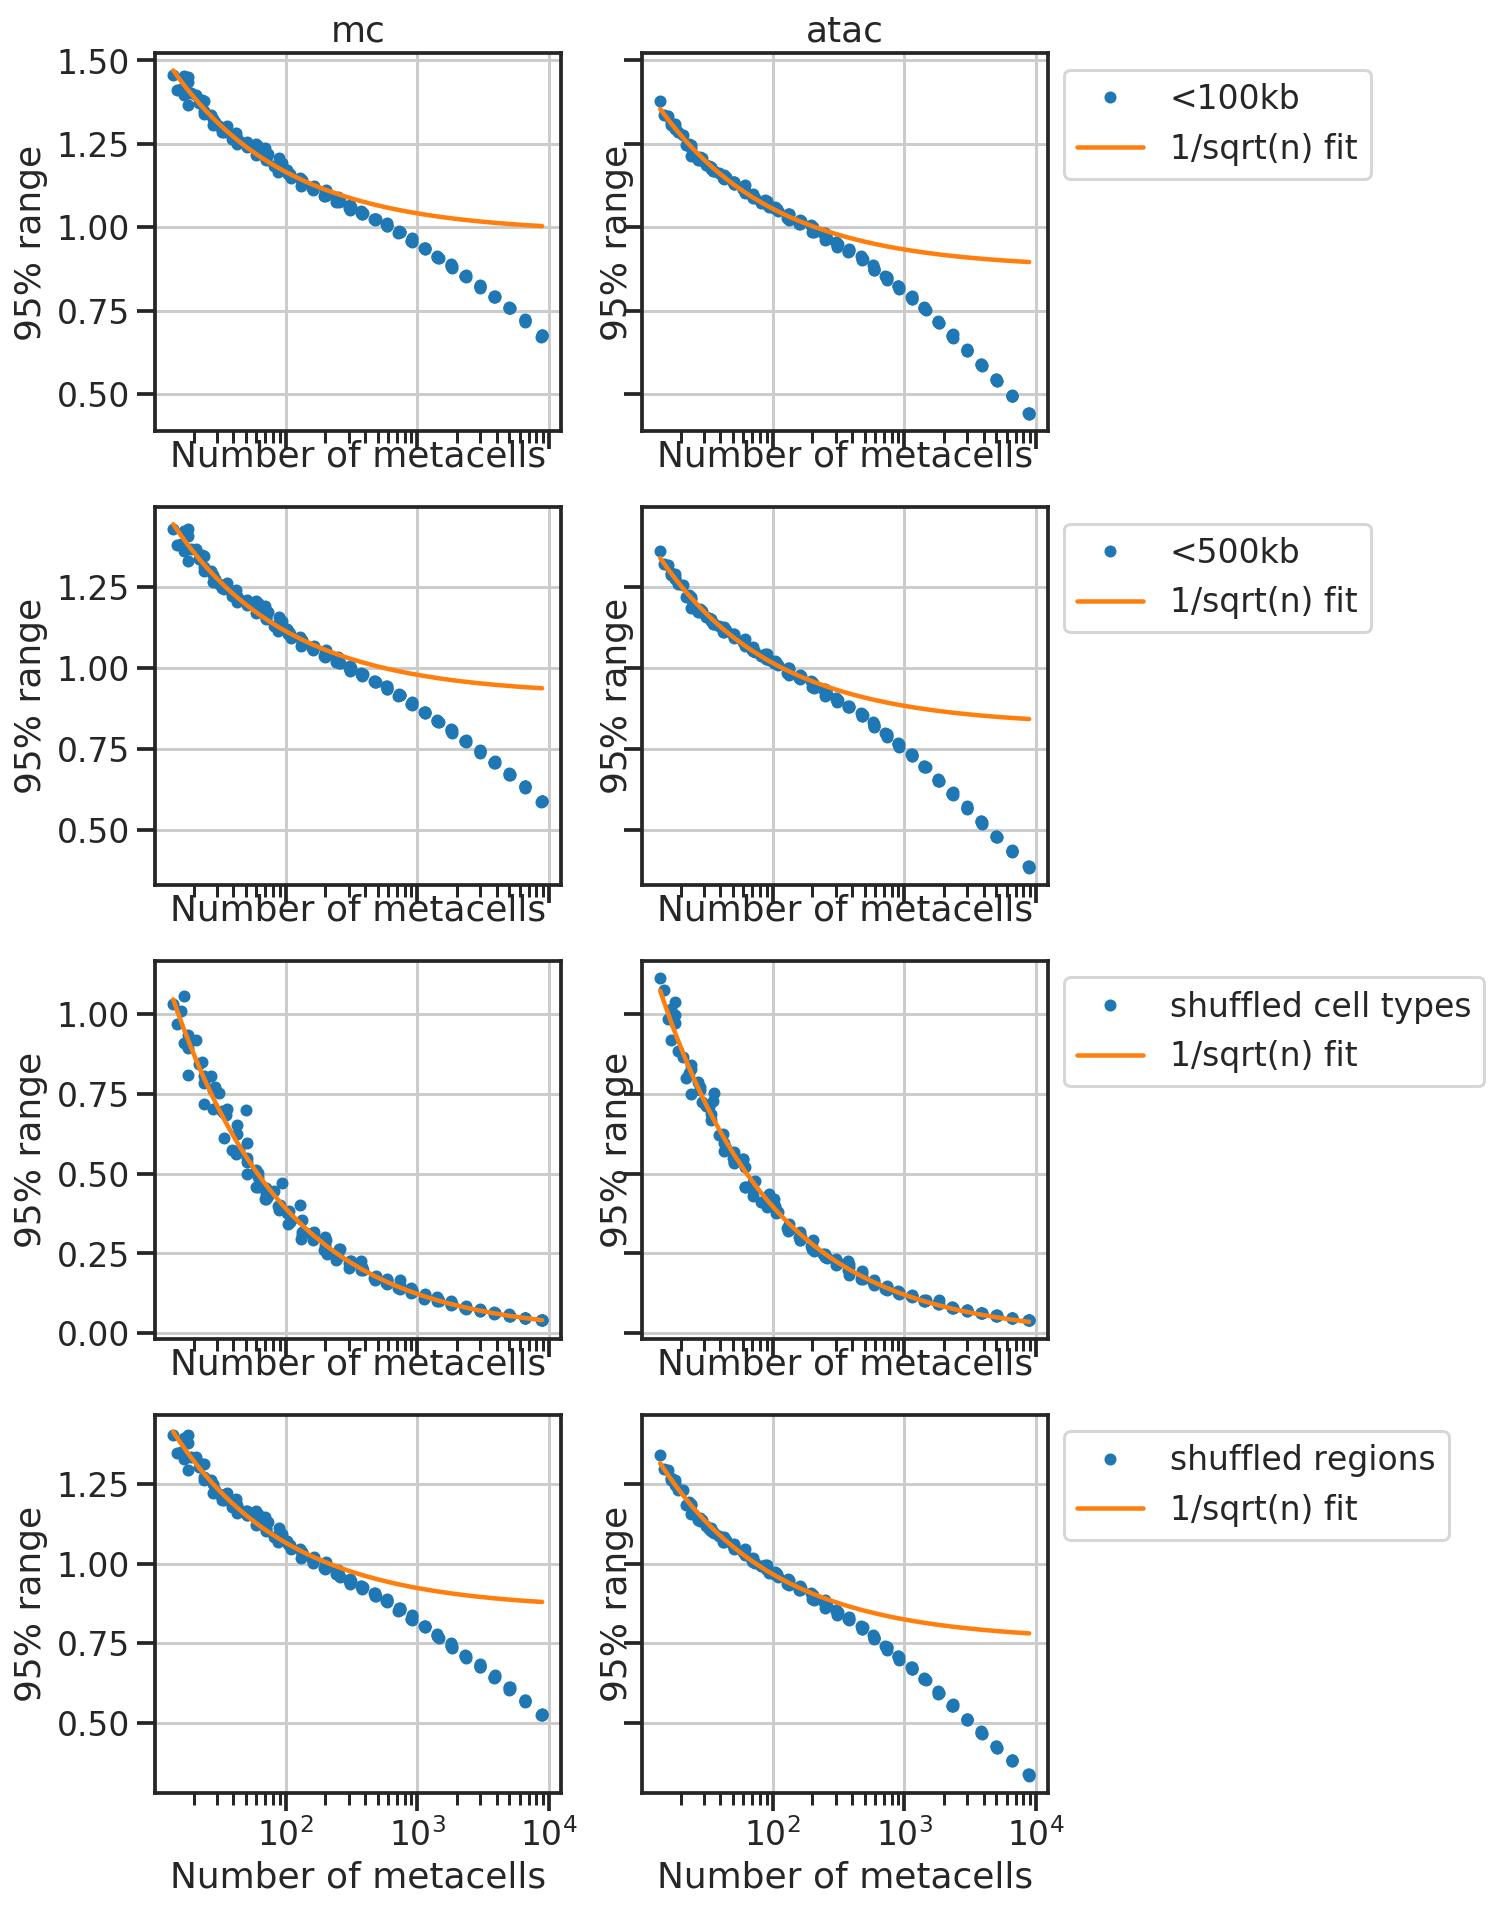

In [19]:
min_nclst_linear = 249

toplot = res_summary
# aranged by mod and track type and replicates
mods = toplot['mod'].unique()
track_names = np.sort(toplot['track_name'].unique())

ny = len(track_names)
nx = len(mods)
fig, axs = plt.subplots(ny, nx, figsize=(nx*4, ny*4), sharex=True, sharey='row')
for i, track_name in enumerate(track_names):    
    for j, mod in enumerate(mods):    
        ax = axs[i,j]
        if i == 0:
            ax.set_title(mod)
        toplot_sub = toplot[((toplot['mod']==mod) & (toplot['track_name']==track_name))].sort_values('num_clst')
        
        x, y = toplot_sub['num_clst'], toplot_sub['interval']
        ax.plot(x, y, 'o', markersize=5, label=track_name)
        
        if track_name == 'shuffled cell types':
            xtofit = x
            ytofit = y
        else:
            xtofit = x[x<=min_nclst_linear]
            ytofit = y[x<=min_nclst_linear]
        
        paras, _ = optimize.curve_fit(fit_func_linear, 1/np.sqrt(xtofit), ytofit)
        yfit = fit_func_linear(1/np.sqrt(x), paras[0], paras[1])
        ax.plot(x, yfit, label='1/sqrt(n) fit')

        ax.set_xlabel('Number of metacells')
        ax.set_ylabel('95% range')
        
    ax.legend(bbox_to_anchor=(1,1), loc='upper left')
# ax.xaxis.set_major_locator(plt.MaxNLocator(4))    
ax.set_xscale('log')
output = output_figures.format('num_metacells_scaling_fit')
if output:
    snmcseq_utils.savefig(fig, output)
    print(output)
plt.show()

<ipython-input-20-56997ed887e3>:56: RuntimeWarning: divide by zero encountered in double_scalars
  ax.annotate("{:.1f}".format((1/xtick)**2),


/cndd2/fangming/projects/scf_enhancers/results/figures/2021-01-08_metacell_corr_res_num_metacells_scaling_fit_v2.pdf


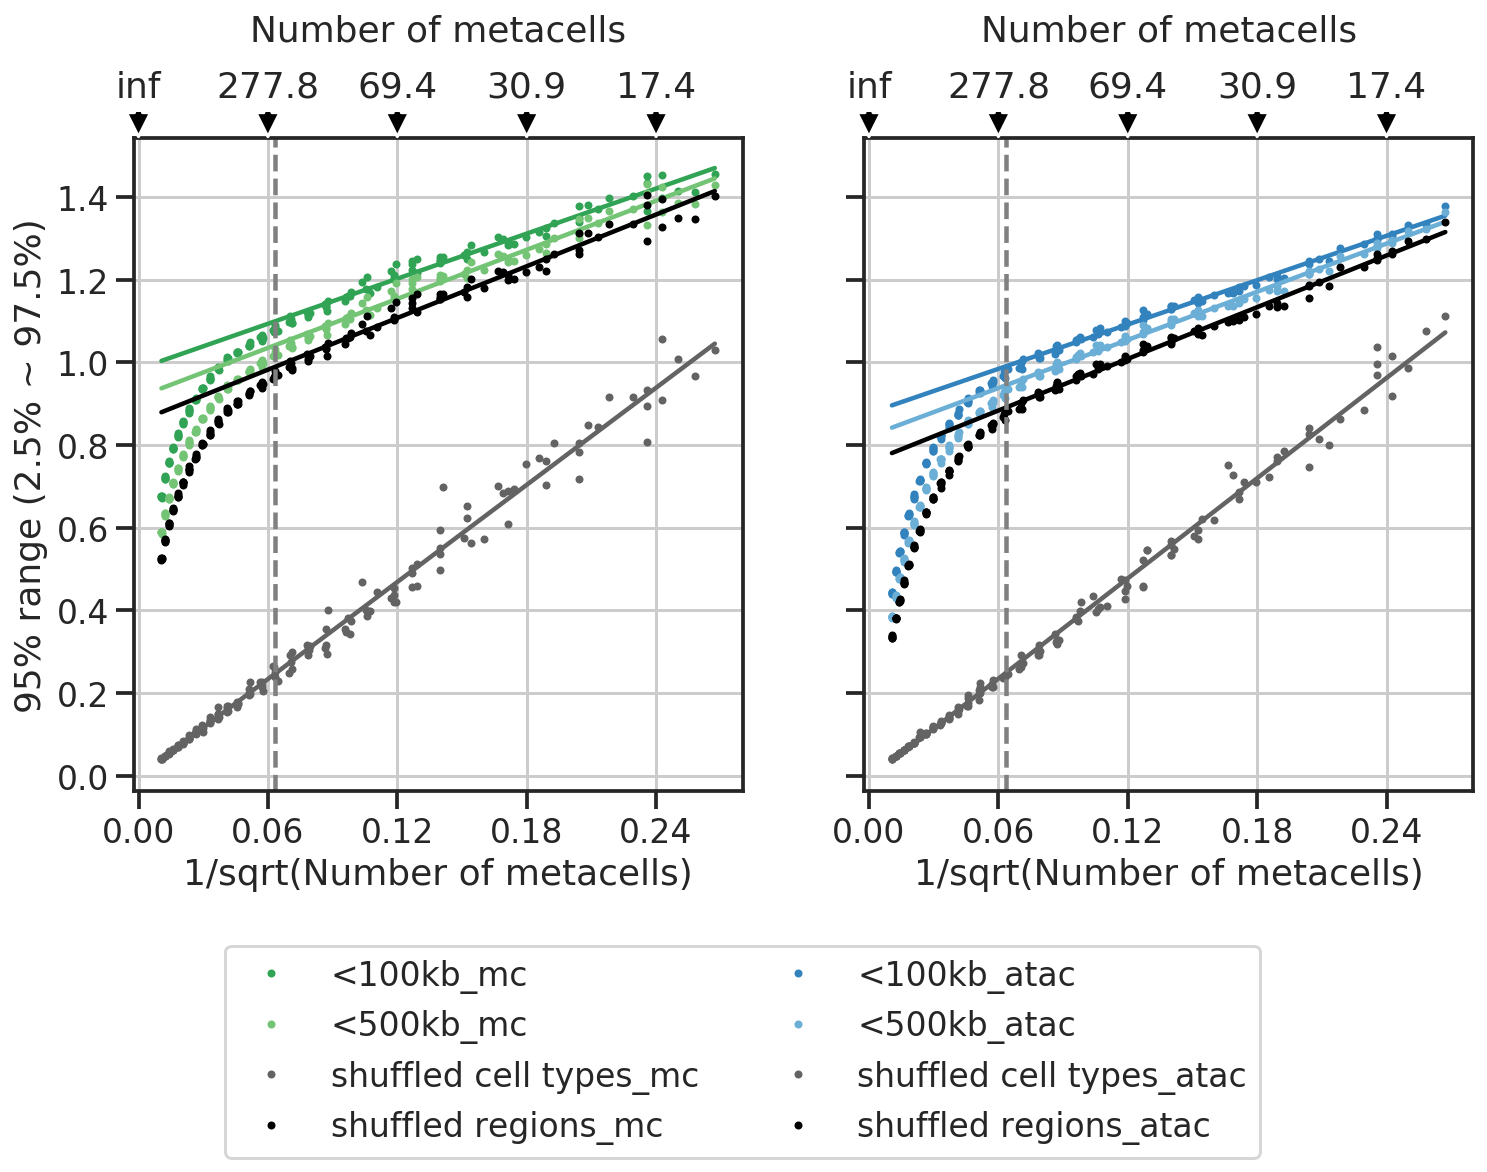

In [20]:
min_nclst_linear = 249

# plot the fitted results
toplot = res_summary
# aranged by mod and track type
mods = toplot['mod'].unique()
track_names = np.sort(toplot['track_name'].unique())

fig, axs = plt.subplots(1, 2, figsize=(6*2, 6), sharey=True, sharex=True)
for j, mod in enumerate(mods):    
    ax = axs[j]
    for i, track_name in enumerate(track_names):    
        label = track_name+'_'+mod
        color = track_color_palette[label]
        toplot_sub = toplot[((toplot['mod']==mod) & (toplot['track_name']==track_name))].sort_values('num_clst')
        
        x, y = toplot_sub['num_clst'], toplot_sub['interval']
        ax.plot(1/np.sqrt(x), y, 'o', markersize=3, label=label, color=color)
        
        if track_name == 'shuffled cell types':
            xtofit = x
            ytofit = y
        else:
            xtofit = x[x<=min_nclst_linear]
            ytofit = y[x<=min_nclst_linear]
            
        paras, _ = optimize.curve_fit(fit_func_linear, 1/np.sqrt(xtofit), ytofit)
        yfit = fit_func_linear(1/np.sqrt(x), paras[0], paras[1])
        ax.plot(1/np.sqrt(x), yfit, color=color)

    ax.set_xlabel('1/sqrt(Number of metacells)')
    if j == 0:
        ax.set_ylabel('95% range (2.5% ~ 97.5%)')
        
ax.xaxis.set_major_locator(plt.MaxNLocator(4))    
handles, labels = snmcseq_utils.combine_legends(axs)
axs[0].legend(handles, labels, bbox_to_anchor=(1,-0.4), loc='center', ncol=2)

# annotate
xmin, xmax = axs[0].get_xlim()
ymin, ymax = axs[0].get_ylim()
ypos = ymax
for ax in axs:
    xticks = np.arange(0, xmax, 0.06)
    ax.set_xticks(xticks)
    ax.set_xticklabels(["{:.2f}".format(tick) for tick in xticks])
    
    ax.axvline(1/np.sqrt(min_nclst_linear), linestyle='--', color='gray')
#     xticks = xticks[((xticks>xmin)&(xticks<xmax))]
#     xticks = ax.get_xticks()
#     xticks = xticks[((xticks>xmin)&(xticks<xmax))]
#     xticks = np.sort(np.hstack([xticks, [1/np.sqrt(min_nclst_linear)]]))
#     ax.set_xticks(xticks)
    
    for xtick in xticks:
        ax.annotate("{:.1f}".format((1/xtick)**2), 
                    xy=(xtick, ypos),
                    annotation_clip=False,
                    ha='center',
                    xytext=(xtick, ypos+0.1),
                    arrowprops=dict(facecolor='black', shrink=0.05), 
                   )
    # xlabel
    ax.annotate("Number of metacells", 
                ha='center',
                xy=(0.5, 1.15),
                xycoords='axes fraction',
                annotation_clip=False,
               )
    
output = output_figures.format('num_metacells_scaling_fit_v2')
if output:
    snmcseq_utils.savefig(fig, output)
    print(output)
plt.show()

249
249
/cndd2/fangming/projects/scf_enhancers/results/figures/2021-01-08_metacell_corr_res_num_metacells_scaling_fit_v3.pdf


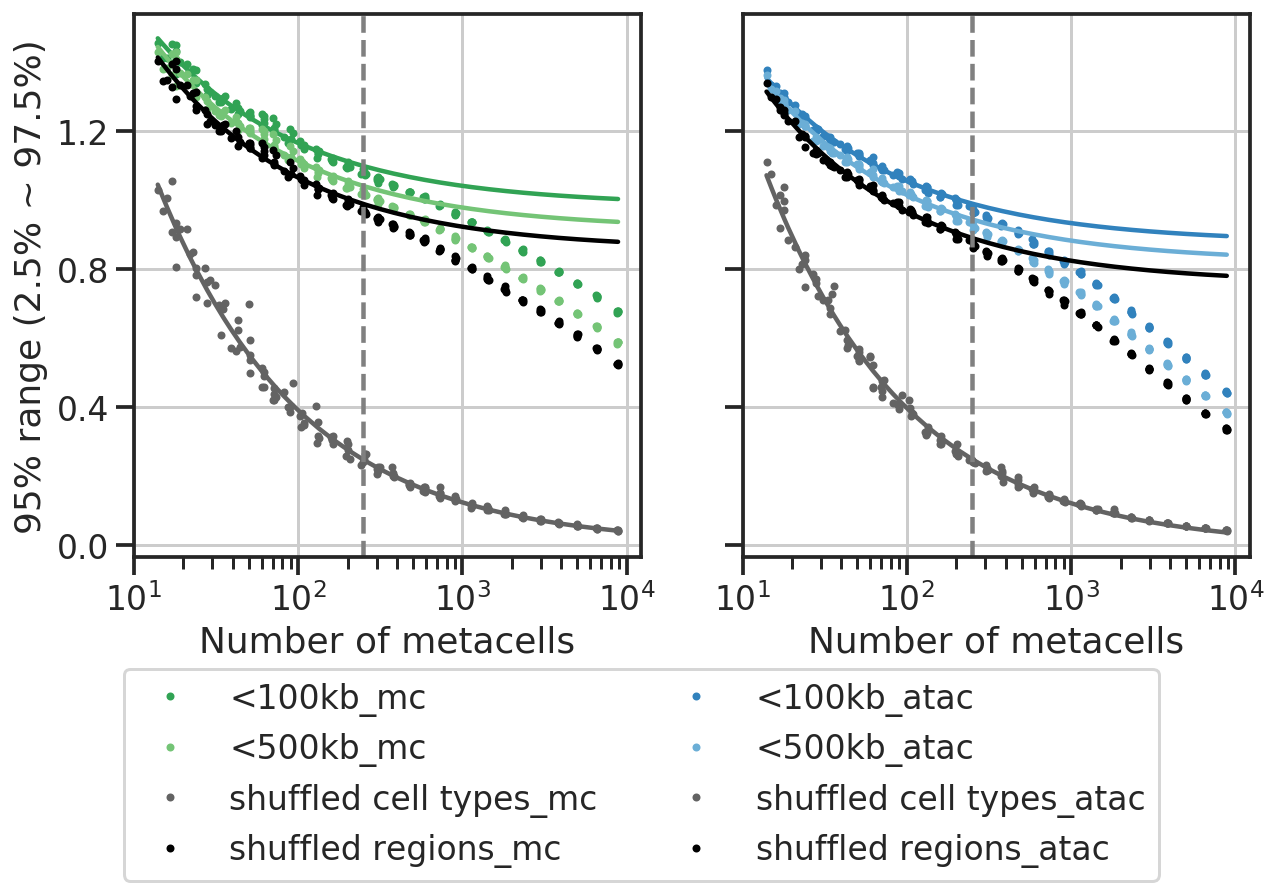

In [21]:
min_nclst_linear = 249

# plot the fitted results
toplot = res_summary
# aranged by mod and track type
mods = toplot['mod'].unique()
track_names = np.sort(toplot['track_name'].unique())

fig, axs = plt.subplots(1, 2, figsize=(5*2, 5), sharey=True, sharex=True)
for j, mod in enumerate(mods):    
    ax = axs[j]
    for i, track_name in enumerate(track_names):    
        label = track_name+'_'+mod
        color = track_color_palette[label]
        toplot_sub = toplot[((toplot['mod']==mod) & (toplot['track_name']==track_name))].sort_values('num_clst')
        
        x, y = toplot_sub['num_clst'], toplot_sub['interval']
#         ax.plot(1/np.sqrt(x), y, 'o', markersize=3, label=label, color=color)
        ax.plot(x, y, 'o', markersize=3, label=label, color=color)
        
        if track_name == 'shuffled cell types':
            xtofit = x
            ytofit = y
        else:
            xtofit = x[x<=min_nclst_linear]
            ytofit = y[x<=min_nclst_linear]
            
        paras, _ = optimize.curve_fit(fit_func_linear, 1/np.sqrt(xtofit), ytofit)
        yfit = fit_func_linear(1/np.sqrt(x), paras[0], paras[1])
        ax.plot(x, np.clip(yfit, 0, 1.5), color=color)

    ax.set_xlabel('Number of metacells')
    if j == 0:
        ax.set_ylabel('95% range (2.5% ~ 97.5%)')

ax.set_xscale('log')
ax.yaxis.set_major_locator(plt.MaxNLocator(4))    
handles, labels = snmcseq_utils.combine_legends(axs)
axs[0].legend(handles, labels, bbox_to_anchor=(1,-0.4), loc='center', ncol=2)

# annotate
xmin, xmax = axs[0].get_xlim()
ymin, ymax = axs[0].get_ylim()
ypos = ymax
for ax in axs:
    print(min_nclst_linear)
    ax.axvline(min_nclst_linear, linestyle='--', color='gray')
    ax.set_xticks(np.hstack([[10, 100, 1000, 10000], 
#                              [min_nclst_linear],
                            ])
                 )
    
output = output_figures.format('num_metacells_scaling_fit_v3')
if output:
    snmcseq_utils.savefig(fig, output)
    print(output)
plt.show()